In [11]:
!pip install pandas numpy scipy scikit-learn seaborn matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [37]:
stocks = pd.read_csv("../Data/sp500_stocks.csv")
companies = pd.read_csv("../Data/sp500_companies.csv")
index = pd.read_csv("../Data/sp500_index.csv")
gold = pd.read_csv("../Data/GOLD.csv")
realestate = pd.read_csv("../Data/Real_Estate_Sales_2001-2021_GL.csv", low_memory=False)
recession = pd.read_csv("../Data/US_Recession.csv")


In [38]:
def standardize_columns(df):
    df.columns = df.columns.str.strip().str.lower()
    return df

stocks = standardize_columns(stocks)
companies = standardize_columns(companies)
index = standardize_columns(index)

In [39]:
# PROCESS S&P 500 COMPANIES

companies['ebitda'] = companies['ebitda'].fillna(companies['ebitda'].median())
companies['revenuegrowth'] = companies['revenuegrowth'].fillna(companies['revenuegrowth'].median())
companies['state'] = companies['state'].fillna("Unknown")
companies['fulltimeemployees'] = companies['fulltimeemployees'].fillna(companies['fulltimeemployees'].median())

def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

financial_cols = ['ebitda', 'revenuegrowth', 'marketcap']
for col in financial_cols:
    if col in companies.columns:
        cap_outliers_iqr(companies, col)

scaler = MinMaxScaler()
for col in financial_cols:
    if col in companies.columns:
        companies[col] = np.where(companies[col] > 0, np.log1p(companies[col]), 0)
        companies[col] = scaler.fit_transform(companies[col].values.reshape(-1, 1))

companies.to_csv("../Data/sp500_companies_cleaned.csv", index=False)
print("S&P 500 Companies dataset processed successfully!")
display(companies.head())
companies.info()

S&P 500 Companies dataset processed successfully!


c:\Users\saipa\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,longbusinesssummary,weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,1.0,1.0,0.248140,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,1.0,1.0,1.000000,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,1.0,1.0,0.621985,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,1.0,1.0,0.437342,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,1.0,1.0,0.589344,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   exchange             502 non-null    object 
 1   symbol               502 non-null    object 
 2   shortname            502 non-null    object 
 3   longname             502 non-null    object 
 4   sector               502 non-null    object 
 5   industry             502 non-null    object 
 6   currentprice         502 non-null    float64
 7   marketcap            502 non-null    float64
 8   ebitda               502 non-null    float64
 9   revenuegrowth        502 non-null    float64
 10  city                 502 non-null    object 
 11  state                502 non-null    object 
 12  country              502 non-null    object 
 13  fulltimeemployees    502 non-null    float64
 14  longbusinesssummary  502 non-null    object 
 15  weight               502 non-null    flo

In [41]:
# PROCESS S&P 500 STOCKS

columns_to_check = ['adj close', 'close', 'high', 'low', 'open', 'volume']
stocks = stocks.dropna(subset=columns_to_check, how='all')

merged_data = pd.merge(stocks, index, on='date', how='inner')

merged_data['date'] = pd.to_datetime(merged_data['date'])

merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['day'] = merged_data['date'].dt.day
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek

#merged_data.drop(columns=['date'], inplace=True)

merged_data.rename(columns={'s&p500': 'index'}, inplace=True)

merged_data.to_csv("../Data/sp500_cleaned.csv", index=False)
print("S&P 500 Stocks dataset processed successfully!")
display(merged_data.head())
merged_data.info()

S&P 500 Stocks dataset processed successfully!


,date,symbol,adj close,close,high,low,open,volume,index,year,month,day,day_of_week
0,2014-12-22,AOS,23.673809,27.674999,27.684999,27.200001,27.309999,852600.0,2078.54,2014,12,22,0
1,2014-12-23,AOS,23.960384,28.010000,28.145000,27.590000,27.795000,973400.0,2082.17,2014,12,23,1
2,2014-12-24,AOS,24.033092,28.094999,28.209999,27.900000,27.900000,233600.0,2081.88,2014,12,24,2
3,2014-12-26,AOS,24.217010,28.309999,28.455000,28.170000,28.250000,360000.0,2088.77,2014,12,26,4
4,2014-12-29,AOS,24.238392,28.334999,28.490000,28.195000,28.299999,391800.0,2090.57,2014,12,29,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423337 entries, 0 to 423336
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         423337 non-null  datetime64[ns]
 1   symbol       423337 non-null  object        
 2   adj close    423337 non-null  float64       
 3   close        423337 non-null  float64       
 4   high         423337 non-null  float64       
 5   low          423337 non-null  float64       
 6   open         423337 non-null  float64       
 7   volume       423337 non-null  float64       
 8   index        423337 non-null  float64       
 9   year         423337 non-null  int32         
 10  month        423337 non-null  int32         
 11  day          423337 non-null  int32         
 12  day_of_week  423337 non-null  int32         
dtypes: datetime64[ns](1), float64(7), int32(4), object(1)
memory usage: 35.5+ MB


In [42]:
# PROCESS GOLD DATA

gold['time'] = pd.to_datetime(gold['time'])
gold.rename(columns={'time': 'date'}, inplace=True)

gold['year'] = gold['date'].dt.year
gold['month'] = gold['date'].dt.month
gold['day'] = gold['date'].dt.day
gold['day_of_week'] = gold['date'].dt.dayofweek
gold['hour'] = gold['date'].dt.hour

for col in ['open', 'high', 'low', 'close']:
    cap_outliers_iqr(gold, col)

gold[['rsi14', 'sma14']] = scaler.fit_transform(gold[['rsi14', 'sma14']])

gold.to_csv("../Data/GOLD_cleaned.csv", index=False)
print("Gold dataset processed successfully!")
display(gold.head())
gold.info()

Gold dataset processed successfully!


,date,open,high,low,close,rsi14,sma14,year,month,day,day_of_week,hour
0,2010-01-03 18:00:00,1098.45,1100.0,1098.05,1099.95,0.842004,0.044514,2010,1,3,6,18
1,2010-01-03 18:05:00,1100.00,1100.3,1099.45,1099.75,0.812047,0.044833,2010,1,3,6,18
2,2010-01-03 18:10:00,1099.70,1100.1,1099.30,1099.45,0.767804,0.045123,2010,1,3,6,18
3,2010-01-03 18:15:00,1099.50,1099.6,1098.50,1099.45,0.767804,0.045376,2010,1,3,6,18
4,2010-01-03 18:20:00,1099.40,1099.6,1098.90,1098.90,0.687633,0.045563,2010,1,3,6,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986004 entries, 0 to 986003
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         986004 non-null  datetime64[ns]
 1   open         986004 non-null  float64       
 2   high         986004 non-null  float64       
 3   low          986004 non-null  float64       
 4   close        986004 non-null  float64       
 5   rsi14        986004 non-null  float64       
 6   sma14        986004 non-null  float64       
 7   year         986004 non-null  int32         
 8   month        986004 non-null  int32         
 9   day          986004 non-null  int32         
 10  day_of_week  986004 non-null  int32         
 11  hour         986004 non-null  int32         
dtypes: datetime64[ns](1), float64(6), int32(5)
memory usage: 71.5 MB


In [43]:
# PROCESS REAL ESTATE DATA

required_columns = ['List Year', 'Date Recorded', 'Town', 'Address', 'Assessed Value', 'Sale Amount', 'Sales Ratio', 'Property Type', 'Residential Type']
realestate_cleaned = realestate.dropna(subset=required_columns)

if 'Date Recorded' in realestate_cleaned.columns:
    realestate_cleaned['Date Recorded'] = pd.to_datetime(realestate_cleaned['Date Recorded'])

    realestate_cleaned['year'] = realestate_cleaned['Date Recorded'].dt.year
    realestate_cleaned['month'] = realestate_cleaned['Date Recorded'].dt.month
    realestate_cleaned['day'] = realestate_cleaned['Date Recorded'].dt.day
    realestate_cleaned['day_of_week'] = realestate_cleaned['Date Recorded'].dt.dayofweek

    realestate_cleaned.drop(columns=['Date Recorded'], inplace=True)

numeric_columns = ['Assessed Value', 'Sale Amount', 'Sales Ratio']
realestate_cleaned[numeric_columns] = realestate_cleaned[numeric_columns].apply(pd.to_numeric, errors='coerce')

def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

realestate_cleaned = remove_outliers_iqr(realestate_cleaned, numeric_columns)

scaler = MinMaxScaler()
realestate_cleaned[numeric_columns] = scaler.fit_transform(realestate_cleaned[numeric_columns])

label_encoder = LabelEncoder()
realestate_cleaned['Town'] = label_encoder.fit_transform(realestate_cleaned['Town'])

realestate_cleaned = pd.get_dummies(realestate_cleaned, columns=['Property Type', 'Residential Type'], drop_first=True)

realestate_cleaned.to_csv('../Data/RealEstate_cleaned.csv', index=False)
print("Real Estate dataset processed successfully!")
display(realestate_cleaned.head())
realestate_cleaned.info()

C:\Users\saipa\AppData\Local\Temp\ipykernel_708\4181379407.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  realestate_cleaned['Date Recorded'] = pd.to_datetime(realestate_cleaned['Date Recorded'])
C:\Users\saipa\AppData\Local\Temp\ipykernel_708\4181379407.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  realestate_cleaned['year'] = realestate_cleaned['Date Recorded'].dt.year
C:\Users\saipa\AppData\Local\Temp\ipykernel_708\4181379407.py:10: SettingWithCopyWarning: 
A value is trying to be set on a cop

Real Estate dataset processed successfully!


,Serial Number,List Year,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Non Use Code,Assessor Remarks,OPM remarks,...,day_of_week,Property Type_Four Family,Property Type_Residential,Property Type_Single Family,Property Type_Three Family,Property Type_Two Family,Residential Type_Four Family,Residential Type_Single Family,Residential Type_Three Family,Residential Type_Two Family
1,20002,2020,3,390 TURNPIKE RD,0.556807,0.711318,0.390944,NaN,NaN,NaN,...,4,False,True,False,False,False,False,True,False,False
3,200212,2020,4,5 CHESTNUT DRIVE,0.286131,0.295662,0.522301,NaN,NaN,NaN,...,1,False,True,False,False,False,False,False,False,False
10,210045,2021,10,89 LONG MEADOW RD,0.505807,0.930447,0.218495,NaN,NaN,NaN,...,4,False,True,False,False,False,False,True,False,False
11,210101,2021,11,43 LEDYARD AVE,0.244580,0.344025,0.338497,NaN,NaN,NaN,...,0,False,True,False,False,False,False,True,False,False
12,20139,2020,9,16 DEEPWOOD DRIVE,0.376562,0.553432,0.317037,NaN,NaN,NaN,...,2,False,True,False,False,False,False,True,False,False


<class 'pandas.core.frame.DataFrame'>
Index: 519474 entries, 1 to 1054157
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Serial Number                   519474 non-null  int64  
 1   List Year                       519474 non-null  int64  
 2   Town                            519474 non-null  int64  
 3   Address                         519474 non-null  object 
 4   Assessed Value                  519474 non-null  float64
 5   Sale Amount                     519474 non-null  float64
 6   Sales Ratio                     519474 non-null  float64
 7   Non Use Code                    115480 non-null  object 
 8   Assessor Remarks                91468 non-null   object 
 9   OPM remarks                     8473 non-null    object 
 10  Location                        138589 non-null  object 
 11  year                            519474 non-null  int32  
 12  month               

In [44]:
# US RECESSION

recession.columns = recession.columns.str.strip()

critical_columns = ['GDP', 'Rate', 'Recession']
recession = recession.dropna(subset=critical_columns)

numerical_cols = recession.select_dtypes(include=['float64', 'int64']).columns
recession[numerical_cols] = recession[numerical_cols].fillna(recession[numerical_cols].median())

categorical_cols = recession.select_dtypes(include=['object']).columns
if not categorical_cols.empty:
    recession[categorical_cols] = recession[categorical_cols].fillna(recession[categorical_cols].mode().iloc[0])

for col in numerical_cols:
    cap_outliers_iqr(recession, col)

scaler = MinMaxScaler()
recession[numerical_cols] = scaler.fit_transform(recession[numerical_cols])

if not categorical_cols.empty:
    label_encoder = LabelEncoder()
    for col in categorical_cols:
        recession[col] = label_encoder.fit_transform(recession[col])

recession.to_csv("../Data/US_Recession_cleaned.csv", index=False)
print("US Recession dataset processed successfully!")
display(recession.head())
recession.info()

print("Dataset preprocessing complete!")


US Recession dataset processed successfully!


,Unnamed: 0,Price_x,INDPRO,CPI,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,GDP,Rate,BBK_Index,Housing_Index,Recession
0,0.000000,0.008556,0.046856,0.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.995788,0.981235,0.0,0.957474,0.00000,0.996359,0.341325,0.008161,0.0
1,0.002915,0.011880,0.051140,0.001183,0.996264,0.0,0.991458,0.984958,0.987719,0.986550,0.998219,0.993983,0.976998,0.0,0.953608,0.00000,0.986650,0.323026,0.009267,0.0
2,0.005831,0.014674,0.055858,0.005914,0.993773,0.0,0.976205,0.967509,0.962573,0.963743,0.969121,0.968712,0.950363,0.0,0.926546,0.00000,1.000000,0.290360,0.010159,0.0
3,0.008746,0.014574,0.053475,0.009463,0.976339,0.0,0.960342,0.943442,0.938012,0.946199,0.956057,0.961492,0.951574,0.0,0.934278,0.00273,0.983010,0.259591,0.010395,0.0
4,0.011662,0.006509,0.058643,0.015968,0.957659,0.0,0.939597,0.927798,0.930994,0.943860,0.971496,0.985560,0.987893,0.0,0.985825,0.00273,0.980583,0.230244,0.010048,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     344 non-null    float64
 1   Price_x        344 non-null    float64
 2   INDPRO         344 non-null    float64
 3   CPI            344 non-null    float64
 4   3 Mo           344 non-null    float64
 5   4 Mo           344 non-null    float64
 6   6 Mo           344 non-null    float64
 7   1 Yr           344 non-null    float64
 8   2 Yr           344 non-null    float64
 9   3 Yr           344 non-null    float64
 10  5 Yr           344 non-null    float64
 11  7 Yr           344 non-null    float64
 12  10 Yr          344 non-null    float64
 13  20 Yr          344 non-null    float64
 14  30 Yr          344 non-null    float64
 15  GDP            344 non-null    float64
 16  Rate           344 non-null    float64
 17  BBK_Index      344 non-null    float64
 18  Housing_In

In [45]:
# Load cleaned datasets
stocks = pd.read_csv("../Data/sp500_cleaned.csv")
companies = pd.read_csv("../Data/sp500_companies_cleaned.csv")
gold = pd.read_csv("../Data/GOLD_cleaned.csv")
realestate = pd.read_csv("../Data/RealEstate_cleaned.csv")
recession = pd.read_csv("../Data/US_Recession_cleaned.csv")

C:\Users\saipa\AppData\Local\Temp\ipykernel_708\3285575739.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  realestate = pd.read_csv("../Data/RealEstate_cleaned.csv")


In [46]:
# Summary statistics
def descriptive_statistics(df, name):
    print(f"\nSummary statistics for {name}:")
    print(df.describe())

In [47]:
# Apply to each dataset
descriptive_statistics(stocks, "S&P 500 Stocks")
descriptive_statistics(companies, "S&P 500 Companies")
descriptive_statistics(gold, "Gold")
descriptive_statistics(realestate, "Real Estate")
descriptive_statistics(recession, "US Recession")



Summary statistics for S&P 500 Stocks:
           adj close          close           high            low  \
count  423337.000000  423337.000000  423337.000000  423337.000000   
mean      100.735001     107.795706     108.985955     106.556769   
std       116.885672     118.980497     120.304820     117.586292   
min         0.459382       0.478500       0.487500       0.473500   
25%        37.859573      43.459999      43.939999      42.970001   
50%        68.470001      75.699997      76.480003      74.870003   
75%       123.049934     130.600006     132.059998     129.130005   
max      1702.530029    1702.530029    1714.750000    1696.900024   

                open        volume          index           year  \
count  423337.000000  4.233370e+05  423337.000000  423337.000000   
mean      107.786785  8.537541e+06    3361.630830    2019.516036   
std       118.978520  4.293479e+07    1078.996496       2.871371   
min         0.481250  0.000000e+00    1829.080000    2014.000000  

In [48]:
# Visualizations
sns.set(style="whitegrid")

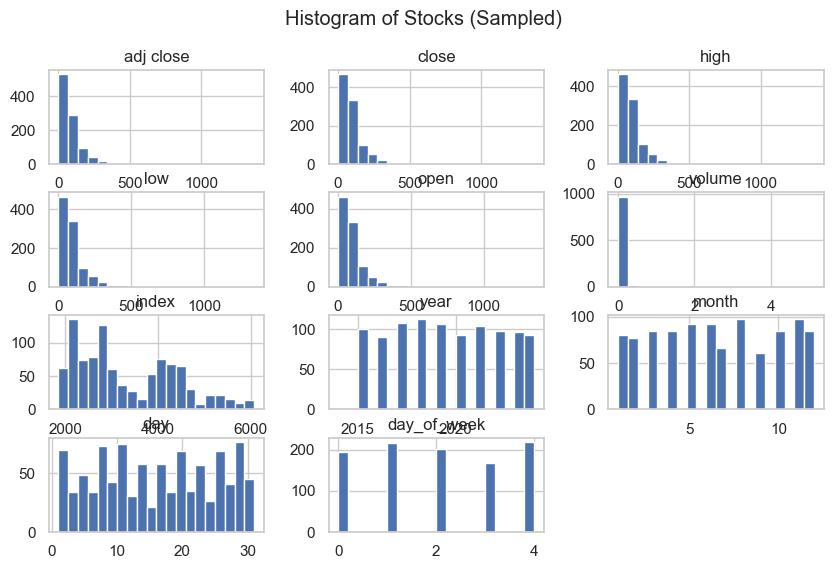

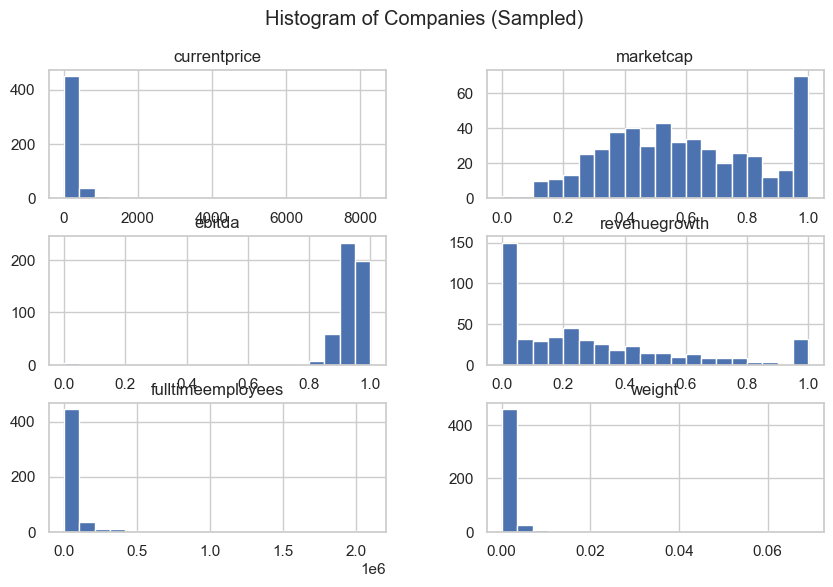

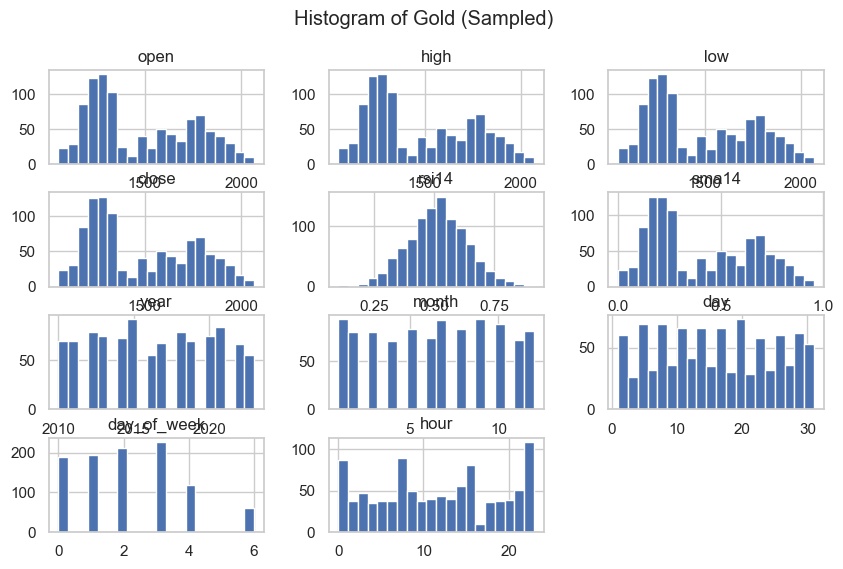

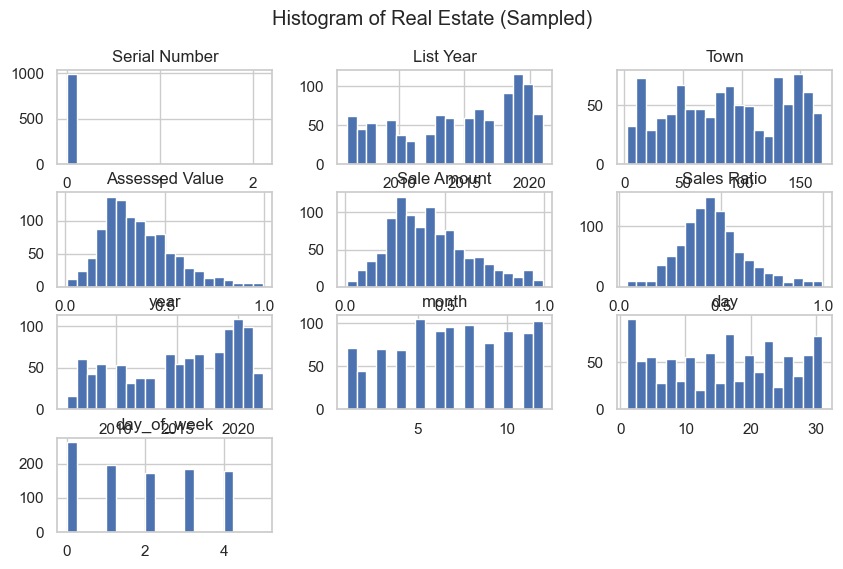

In [49]:
# Histograms with limited data
for df, name in zip([stocks, companies, gold, realestate, recession], 
                    ["Stocks", "Companies", "Gold", "Real Estate"]):
    # Sample a limited number of rows
    sampled_df = df.sample(n=1000, random_state=42) if len(df) > 1000 else df
    
    # Histogram plot
    sampled_df.hist(bins=20, figsize=(10, 6))
    plt.suptitle(f"Histogram of {name} (Sampled)")
    plt.show()


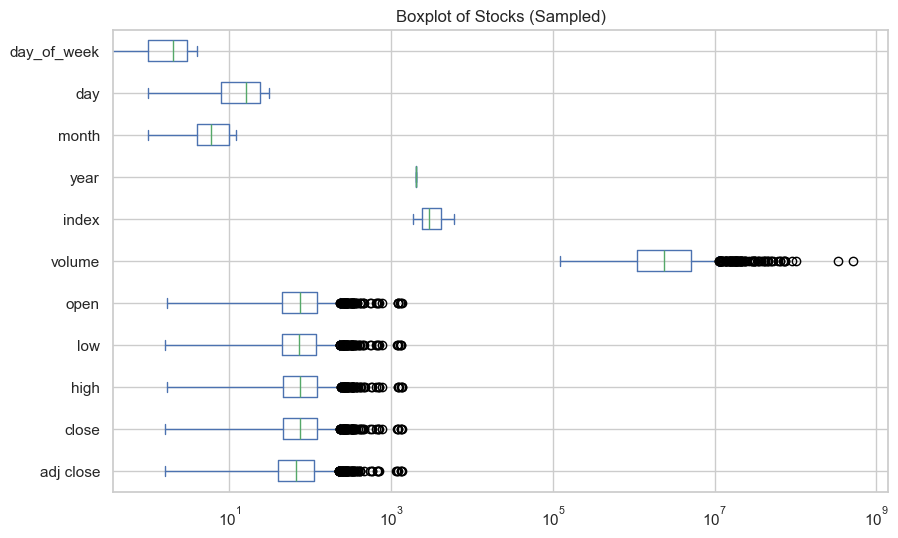

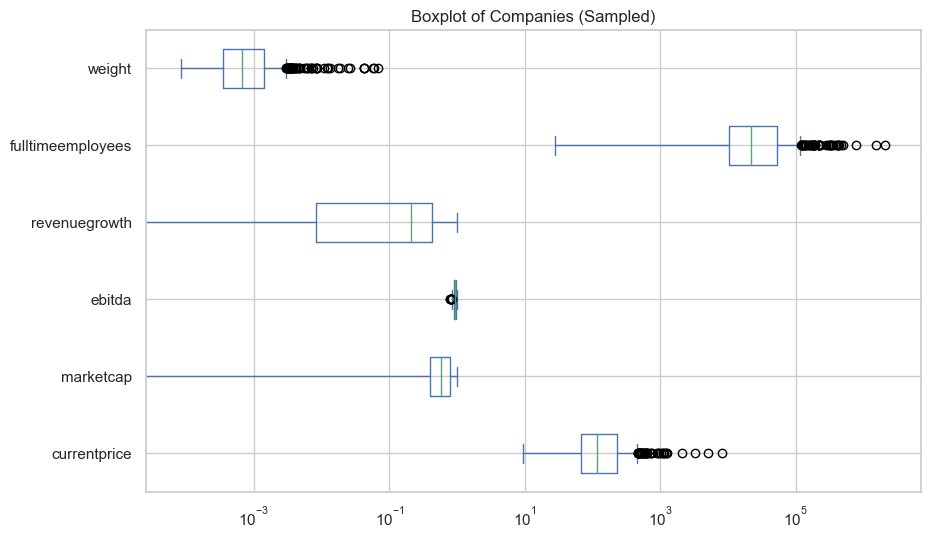

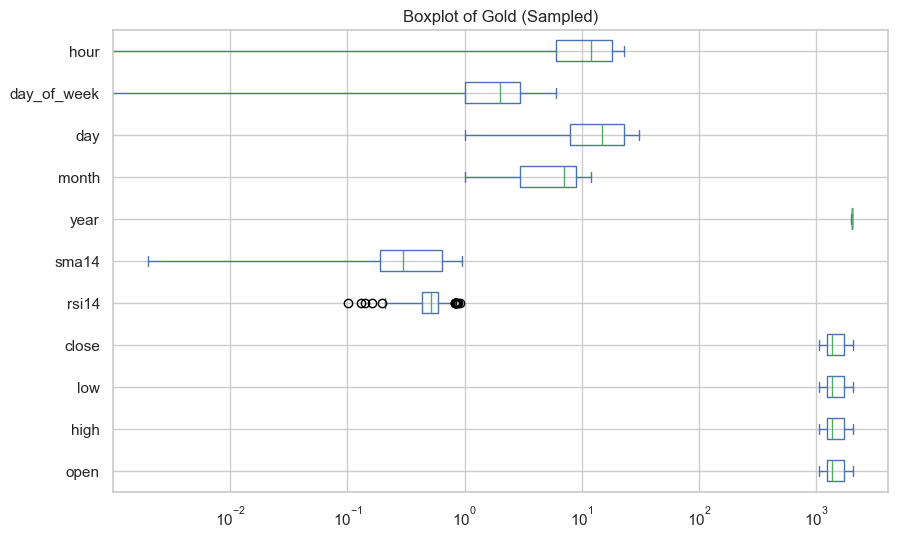

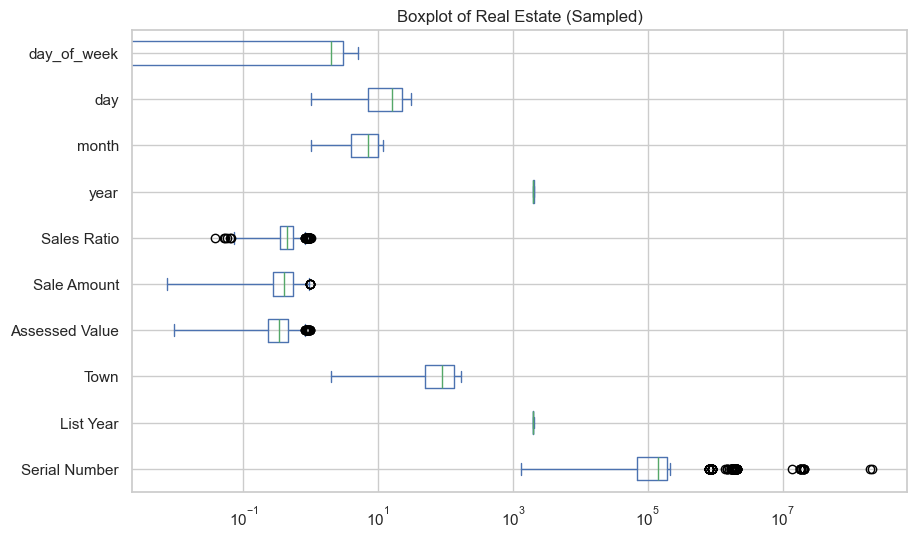

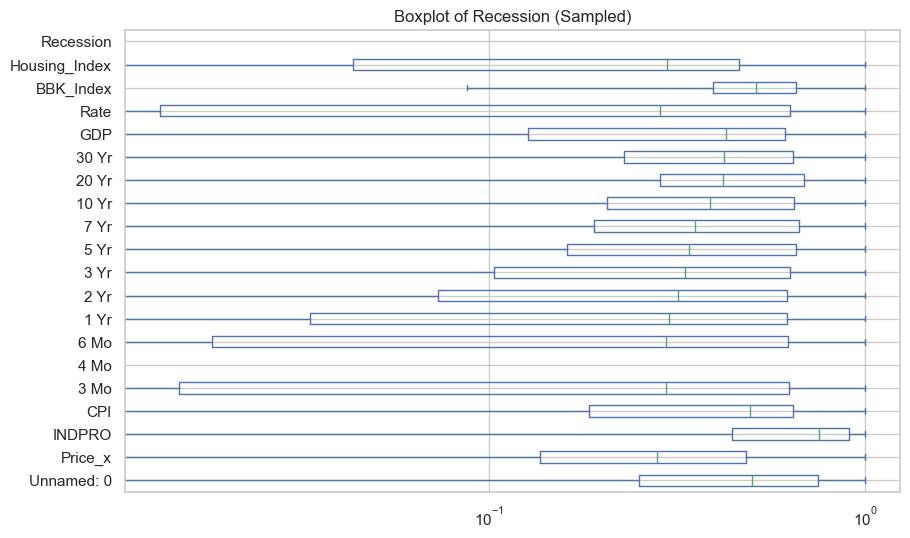

In [50]:
# Limit data for box plots using sampling
for df, name in zip([stocks, companies, gold, realestate, recession], 
                    ["Stocks", "Companies", "Gold", "Real Estate", "Recession"]):
    sampled_df = df.sample(n=1000, random_state=42) if len(df) > 1000 else df  # Limit to 1000 rows
    sampled_df.plot(kind='box', figsize=(10, 6), vert=False, logx=True)
    plt.title(f"Boxplot of {name} (Sampled)")
    plt.show()


In [51]:
df_check1 = pd.read_csv("../Data/sp500_cleaned.csv")
print(df_check1.columns)
df_check2 = pd.read_csv("../Data/sp500_companies_cleaned.csv")
print(df_check2.columns)



Index(['date', 'symbol', 'adj close', 'close', 'high', 'low', 'open', 'volume',
       'index', 'year', 'month', 'day', 'day_of_week'],
      dtype='object')
Index(['exchange', 'symbol', 'shortname', 'longname', 'sector', 'industry',
       'currentprice', 'marketcap', 'ebitda', 'revenuegrowth', 'city', 'state',
       'country', 'fulltimeemployees', 'longbusinesssummary', 'weight'],
      dtype='object')


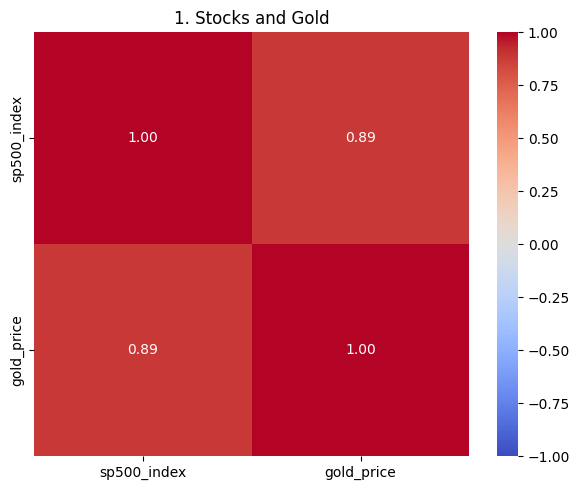

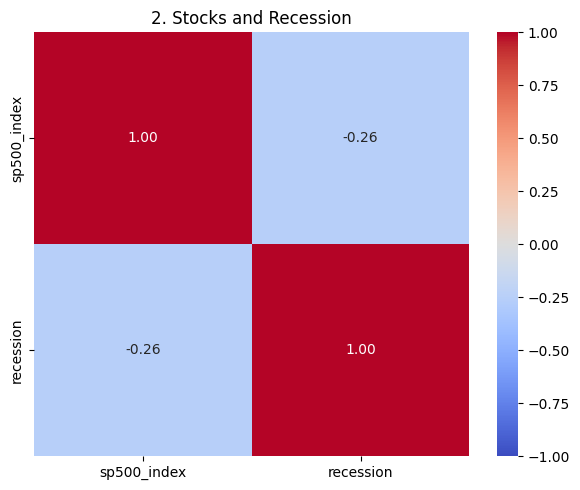

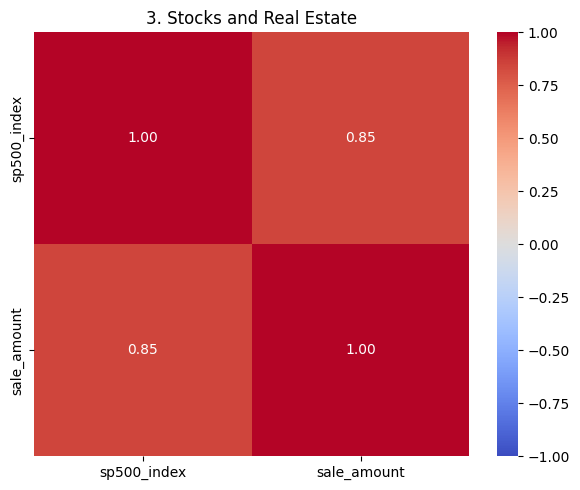

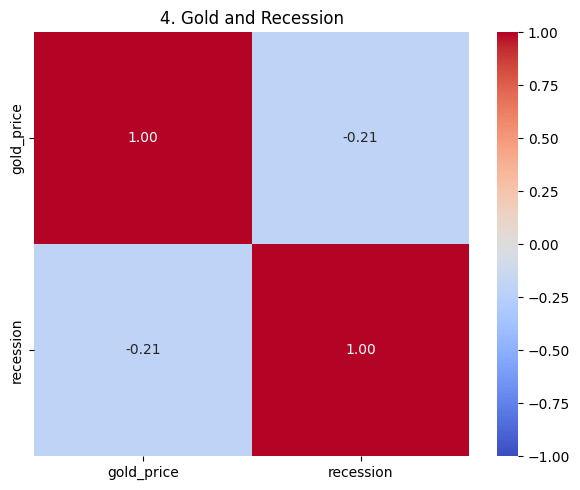

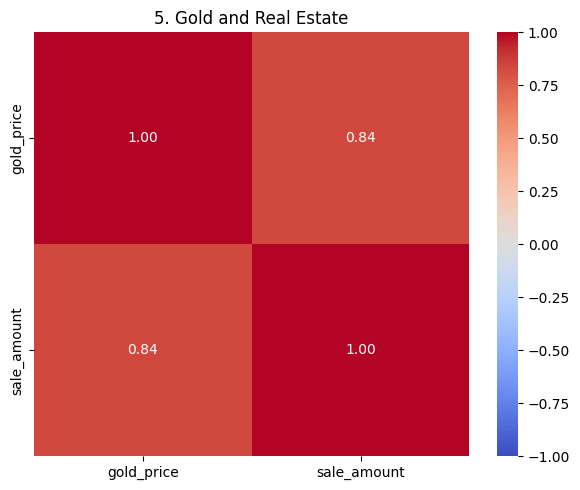

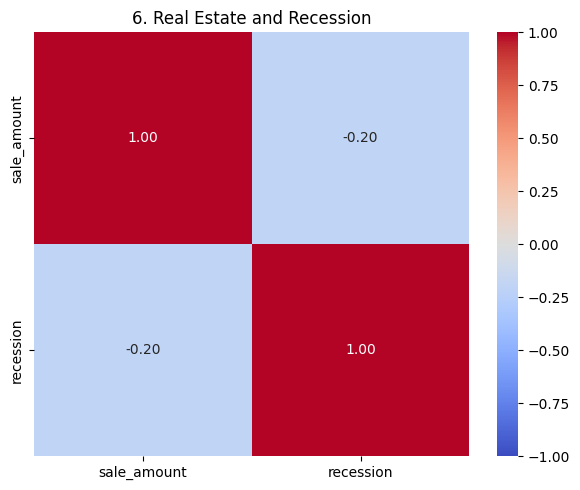

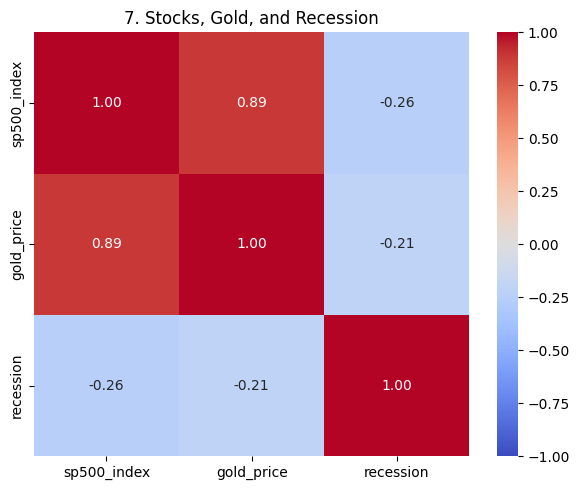

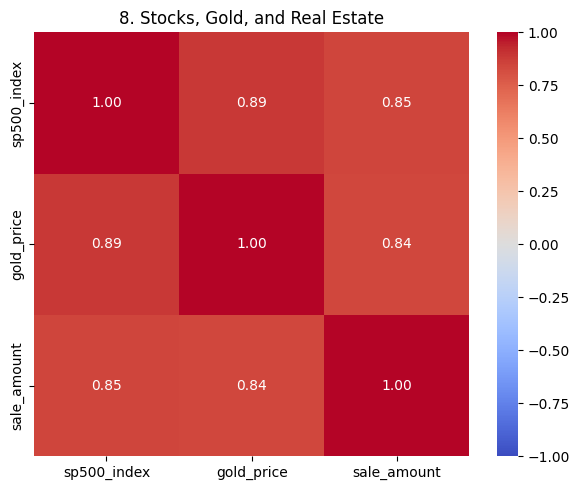

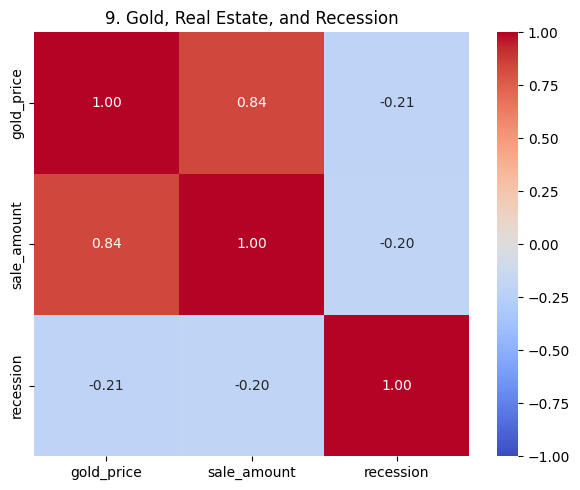

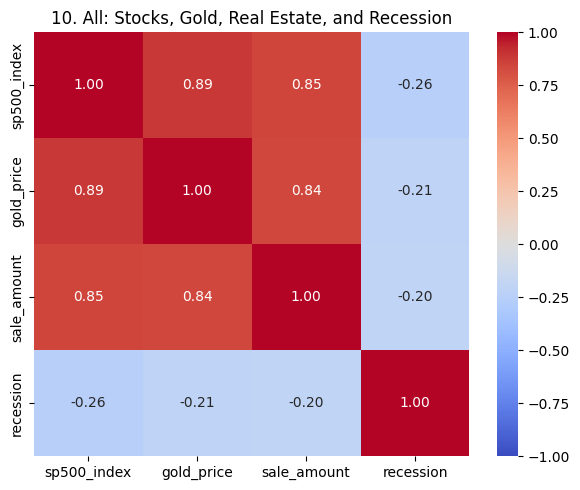

In [4]:
def plot_heatmap(df, columns, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Align dates monthly
stock_monthly = stock_data.groupby(stock_data['date'].dt.to_period('M'))[['sp500_index']].mean().reset_index()
stock_monthly['date'] = stock_monthly['date'].dt.to_timestamp()
gold_monthly = gold.groupby(gold['date'].dt.to_period('M'))[['close']].mean().reset_index()
gold_monthly.rename(columns={'close': 'gold_price'}, inplace=True)
gold_monthly['date'] = gold_monthly['date'].dt.to_timestamp()
realestate_cleaned['date'] = pd.to_datetime(realestate_cleaned['year'].astype(str) + '-' + realestate_cleaned['month'].astype(str) + '-01')
realestate_monthly = realestate_cleaned.groupby('date')[['sale_amount']].mean().reset_index()
merged = stock_monthly.merge(gold_monthly, on='date', how='inner')
merged = merged.merge(realestate_monthly, on='date', how='inner')
merged = merged.merge(recession[['date', 'recession']], on='date', how='inner')

# Heatmaps
plot_heatmap(merged, ['sp500_index', 'gold_price'], "1. Stocks and Gold")
plot_heatmap(merged, ['sp500_index', 'recession'], "2. Stocks and Recession")
plot_heatmap(merged, ['sp500_index', 'sale_amount'], "3. Stocks and Real Estate")
plot_heatmap(merged, ['gold_price', 'recession'], "4. Gold and Recession")
plot_heatmap(merged, ['gold_price', 'sale_amount'], "5. Gold and Real Estate")
plot_heatmap(merged, ['sale_amount', 'recession'], "6. Real Estate and Recession")
plot_heatmap(merged, ['sp500_index', 'gold_price', 'recession'], "7. Stocks, Gold, and Recession")
plot_heatmap(merged, ['sp500_index', 'gold_price', 'sale_amount'], "8. Stocks, Gold, and Real Estate")
plot_heatmap(merged, ['gold_price', 'sale_amount', 'recession'], "9. Gold, Real Estate, and Recession")
plot_heatmap(merged, ['sp500_index', 'gold_price', 'sale_amount', 'recession'], "10. All: Stocks, Gold, Real Estate, and Recession")

In [6]:
# Merge all datasets
merged = stock_monthly.merge(gold_monthly, on='date', how='inner')
merged = merged.merge(realestate_monthly, on='date', how='inner')
merged = merged.merge(recession[['date', 'recession']], on='date', how='inner')

# Filter to only recession periods
recession_only = merged[merged['recession'] == 1]
recession_only.head()



,date,sp500_index,gold_price,sale_amount,recession
0,2014-12-01,0.058925,0.135922,0.368759,1
1,2015-01-01,0.046724,0.188375,0.365648,1
2,2015-02-01,0.059400,0.166787,0.362161,1
3,2015-03-01,0.058882,0.115578,0.357968,1
4,2015-04-01,0.062373,0.135563,0.373479,1


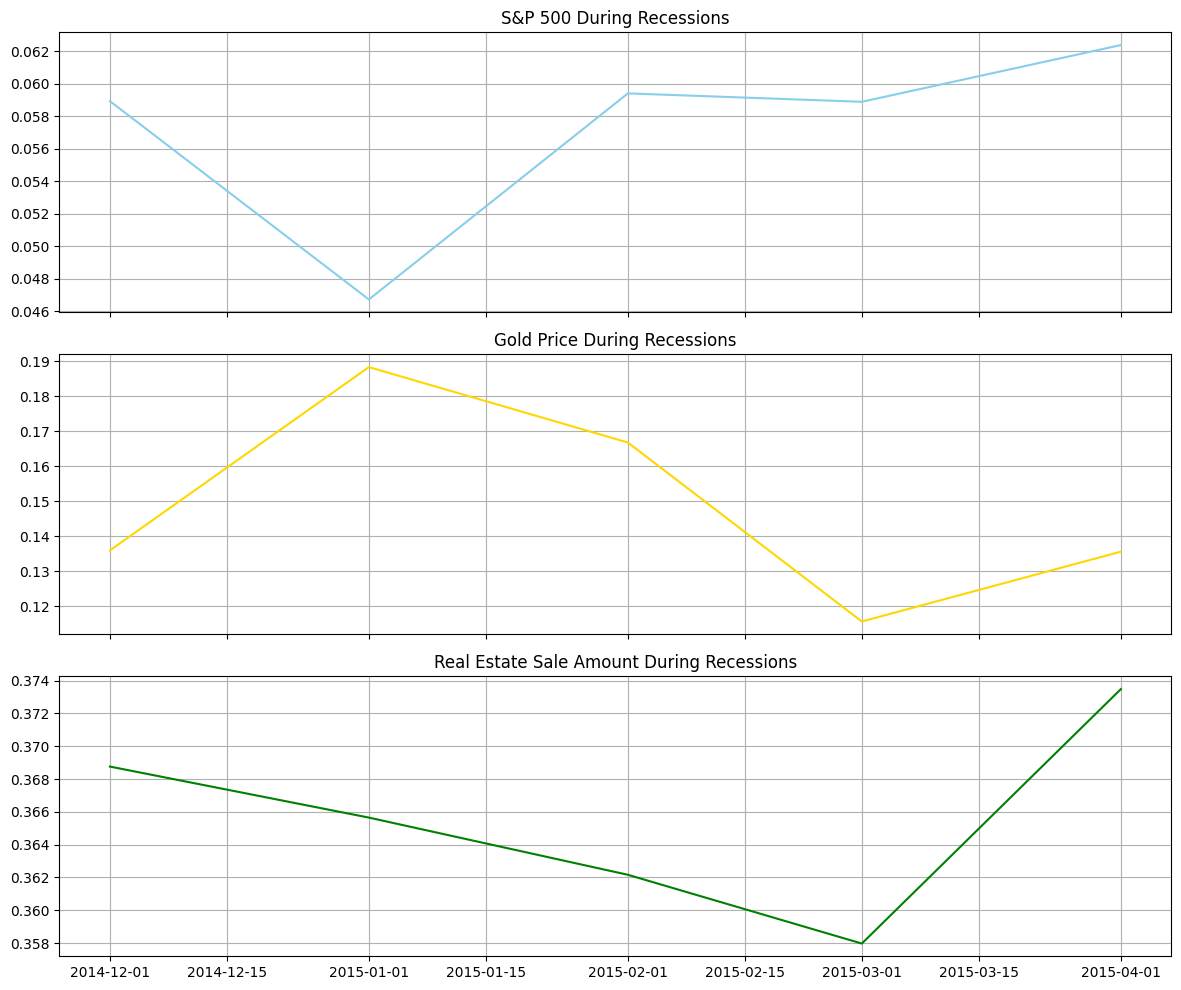

In [9]:
# Recession-only asset trends
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axs[0].plot(recession_only['date'], recession_only['sp500_index'], label='S&P 500', color='skyblue')
axs[0].set_title("S&P 500 During Recessions")
axs[1].plot(recession_only['date'], recession_only['gold_price'], label='Gold Price', color='gold')
axs[1].set_title("Gold Price During Recessions")
axs[2].plot(recession_only['date'], recession_only['sale_amount'], label='Real Estate Sale Amount', color='green')
axs[2].set_title("Real Estate Sale Amount During Recessions")
for ax in axs:
    ax.grid(True)
plt.tight_layout()
plt.show()

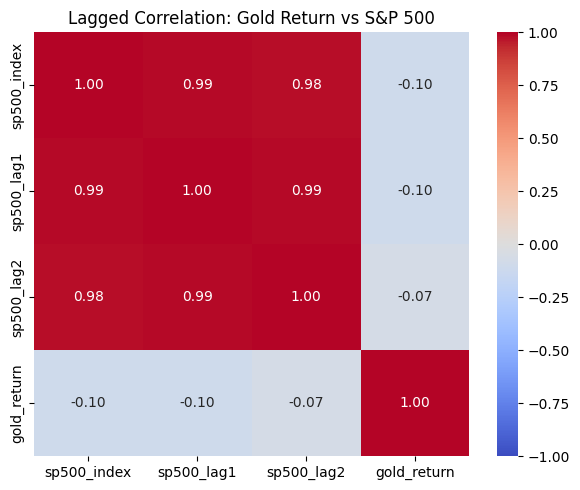

In [10]:

# Lagged Correlation: Gold after Stocks
merged['sp500_lag1'] = merged['sp500_index'].shift(1)
merged['sp500_lag2'] = merged['sp500_index'].shift(2)
merged['gold_return'] = merged['gold_price'].pct_change()
corr_lag = merged[['sp500_index', 'sp500_lag1', 'sp500_lag2', 'gold_return']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_lag, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Lagged Correlation: Gold Return vs S&P 500")
plt.tight_layout()
plt.show()